In [3]:
import numpy as np
import torch
import torch.nn as nn
import os
import matplotlib.pyplot as plt
import random
from torchsummary import summary
from torchvision import datasets, transforms, io
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import functional as F
from PIL import Image
from pathlib import Path
from tqdm import tqdm

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
'''
In the cityscapes dataset only 19 labels are included in evaluation
therefore i remapped the 34 original classes to 19, considering the remaining 15 as void
as suggested by the dataset documentation
'''

'''
Dictionary to encode the labels remapping
'''
label_to_trainid = {
    7:0, 8:1, 11:2, 12:3, 13:4, 17:5, 19:6, 20:7, 21:8, 22:9,
    23:10, 24:11, 25:12, 26:13, 27:14, 28:15, 31:16, 32:17, 33:18
}

'''
Function that converts the dataset labels(34) to the training/testing labels(19)
The original labels from 0-33 are remapped into 0-18 following the scheme at this link:
https://github.com/mcordts/cityscapesScripts/blob/878f1d05b1676c669d977a91831ea800482e36c4/cityscapesscripts/helpers/labels.py#L62
'''
def convert_labelIds_to_trainIds(label_img):
    label_copy = torch.full_like(label_img, 255, dtype=torch.long)
    for k, v in label_to_trainid.items():
        label_copy[label_img == k] = v
    return label_copy

# Dataset definition

In [6]:
'''
Custom dataset to retrieve the dataset image, coloured masks and labelIds masks
coloured masks will be used only to obtain a visual feedback about the segmentation
while labelIds masks will be used to train and test the network
'''
class CityscapeDataset(Dataset):
    def __init__(self, root_path="./data", test=False, image_transform=None, mask_transform=None, joint_transform=None):
        self.root_path = Path(root_path)
        self.mask_pattern = "**/*_gtFine_color.png"
        self.labelIds_pattern = "**/*_labelIds.png"
        self.image_pattern = "**/*.png"

        if test:
            self.images = sorted(self.root_path.joinpath("Cityscape Dataset/leftImg8bit/val").glob(self.image_pattern))
            self.masks = sorted(self.root_path.joinpath("Fine Annotations/gtFine/val").glob(self.mask_pattern))
            self.labelIds = sorted(self.root_path.joinpath("Fine Annotations/gtFine/val").glob(self.labelIds_pattern))
        else:
            self.images = sorted(self.root_path.joinpath("Cityscape Dataset/leftImg8bit/train/").glob(self.image_pattern))
            self.masks = sorted(self.root_path.joinpath("Fine Annotations/gtFine/train/").glob(self.mask_pattern))
            self.labelIds = sorted(self.root_path.joinpath("Fine Annotations/gtFine/train").glob(self.labelIds_pattern))

        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.joint_transform = joint_transform

    def __getitem__(self, index):
        img = Image.open(self.images[index]).convert('RGB') # Ensure image is in RGB
        mask = Image.open(self.masks[index]).convert('RGB') # Load coloured mask as RGB
        labelId = Image.open(self.labelIds[index]).convert('L') # Load labelId as grayscale

        if self.joint_transform:
            img, mask, labelId = self.joint_transform(img, mask, labelId)
        if self.image_transform:
            img = self.image_transform(img)
        if self.mask_transform:
            mask = self.mask_transform(mask)
            labelId = self.mask_transform(labelId)

        # dataset ids conversion to train ids
        labelId = convert_labelIds_to_trainIds(labelId)

        return img, mask, labelId

    def __len__(self):
        return len(self.images)

# Net definition

## Encoder

In [7]:
class conv_block(nn.Module):
    def __init__(self, in_ch, n_filters=64, dropout_prob=0.3, max_pooling=True):
        super().__init__()

        self.conv_1 = nn.Conv2d(in_ch, n_filters, kernel_size=3, padding='same')
        self.conv_2 = nn.Conv2d(n_filters, n_filters, kernel_size=3, padding='same')
        self.activation = nn.ReLU()
        self.max_pooling = max_pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) if self.max_pooling else None
        self.dropout_prob = dropout_prob
        self.dropout = nn.Dropout(p=dropout_prob)
        self.batch_norm = nn.BatchNorm2d(n_filters)

    def forward(self, x):
        out = self.conv_1(x)
        out = self.activation(out)
        out = self.conv_2(out)
        out = self.activation(out)
        out = self.batch_norm(out)
        if self.dropout_prob > 0:
            out = self.dropout(out)

        skip_connection = out.clone()
        if self.max_pooling:
            next_layer = self.pool(out)
        else:
            next_layer = out

        return next_layer, skip_connection

## Decoder

In [61]:
class upsampling_block(nn.Module):
    def __init__(self, in_ch, skip_ch, n_filters=64):
        super().__init__()

        self.upsample = nn.ConvTranspose2d(in_ch, in_ch//2, kernel_size=2, stride=(2, 2), padding=0)
        self.conv_1 = nn.Conv2d(in_ch//2 + skip_ch, n_filters, kernel_size=3, padding='same')
        self.conv_2 = nn.Conv2d(n_filters, n_filters, kernel_size=3, padding='same')
        self.activation = nn.ReLU()


    def forward(self, x, skip):
        conv = self.upsample(x)
        conv = torch.cat([conv, skip], dim=1)
        conv = self.conv_1(conv)
        conv = self.activation(conv)
        conv = self.conv_2(conv)
        conv = self.activation(conv)

        return conv

## Final Model

In [9]:
class UNet(nn.Module):
    def __init__(self, in_ch=3, n_filters=64, n_classes=19):
        super().__init__()
        self.conv_layer_1 = conv_block(in_ch, n_filters, dropout_prob=0, max_pooling=True)
        self.conv_layer_2 = conv_block(n_filters, n_filters*2, dropout_prob=0, max_pooling=True)
        self.conv_layer_3 = conv_block(n_filters*2, n_filters*4, dropout_prob=0, max_pooling=True)
        self.conv_layer_4 = conv_block(n_filters*4, n_filters*8, dropout_prob=0.3, max_pooling=True)
        self.conv_layer_5 = conv_block(n_filters*8, n_filters*16, dropout_prob=0.3, max_pooling=False)

        self.upsample_layer_1 = upsampling_block(n_filters*16, n_filters*8, n_filters*8)
        self.upsample_layer_2 = upsampling_block(n_filters*8, n_filters*4, n_filters*4)
        self.upsample_layer_3 = upsampling_block(n_filters*4, n_filters*2, n_filters*2)
        self.upsample_layer_4 = upsampling_block(n_filters*2, n_filters, n_filters)

        self.last_conv = nn.Sequential(
            nn.Conv2d(n_filters, n_filters, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Conv2d(n_filters, n_classes, kernel_size=1, padding='same')
        )

    def forward(self, x):
        conv_1_next, conv_1_skip = self.conv_layer_1(x)
        conv_2_next, conv_2_skip = self.conv_layer_2(conv_1_next)
        conv_3_next, conv_3_skip = self.conv_layer_3(conv_2_next)
        conv_4_next, conv_4_skip = self.conv_layer_4(conv_3_next)
        conv_5_next, conv_5_skip = self.conv_layer_5(conv_4_next)

        out = self.upsample_layer_1(conv_5_next, conv_4_skip)
        out = self.upsample_layer_2(out, conv_3_skip)
        out = self.upsample_layer_3(out, conv_2_skip)
        out = self.upsample_layer_4(out, conv_1_skip)
        out = self.last_conv(out)

        return out

In [10]:
# Initializing the model
unet = UNet().to(device)

# Printing the model architecture and number of parameters
summary(unet, (3, 128, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 256]           1,792
              ReLU-2         [-1, 64, 128, 256]               0
            Conv2d-3         [-1, 64, 128, 256]          36,928
              ReLU-4         [-1, 64, 128, 256]               0
       BatchNorm2d-5         [-1, 64, 128, 256]             128
         MaxPool2d-6          [-1, 64, 64, 128]               0
        conv_block-7  [[-1, 64, 64, 128], [-1, 64, 128, 256]]               0
            Conv2d-8         [-1, 128, 64, 128]          73,856
              ReLU-9         [-1, 128, 64, 128]               0
           Conv2d-10         [-1, 128, 64, 128]         147,584
             ReLU-11         [-1, 128, 64, 128]               0
      BatchNorm2d-12         [-1, 128, 64, 128]             256
        MaxPool2d-13          [-1, 128, 32, 64]               0
       conv_block-14  [[-

# Transformers

In [9]:
'''
Before to actually train the network it is important to extract the mean and the standard deviation (std) of the 
training images in order to normalize the pixel values in the training and testing phase
'''
dataset = datasets.ImageFolder(
    root='/kaggle/input/cityscape-dataset/Cityscape Dataset/leftImg8bit/train',
    transform=transforms.ToTensor()
)

loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=False, num_workers=2)

mean = 0.
std = 0.
total_images = 0

for images, _ in tqdm(loader, desc="mean/std", total=len(loader), unit="batch"):
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    total_images += batch_samples

mean /= total_images
std /= total_images

print("Mean:", mean)
print("Std:", std)


mean/std: 100%|██████████| 47/47 [04:24<00:00,  5.63s/batch]

Mean: tensor([0.2869, 0.3251, 0.2839])
Std: tensor([0.1761, 0.1810, 0.1777])


In [11]:
# Previously computed mean and std for the Cityscapes training dataset
mean = torch.tensor([0.2869, 0.3251, 0.2839])
std = torch.tensor([0.1761, 0.1810, 0.1777])
print(mean)
print(std)

tensor([0.2869, 0.3251, 0.2839])
tensor([0.1761, 0.1810, 0.1777])


In [69]:
# Transform definition to preprocess data before passing them through the model
'''
These two transforms should be used for validation and testing because they don't apply
any data augmentation to the dataset
'''
image_transforms = transforms.Compose([
            transforms.Resize((128, 256), interpolation=transforms.InterpolationMode.NEAREST),
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x[0:3]),
            transforms.Normalize(mean, std)
])

mask_transforms = transforms.Compose([
            transforms.Resize((128, 256), interpolation=transforms.InterpolationMode.NEAREST),
            # we cannot use ToTensor() to transform the mask to tensor because we want to keep the
            # mask values integer
            transforms.Lambda(lambda x: torch.tensor(np.array(x)).long())
])

In [13]:
# Data augmentation performed on both images and masks
class JointTransform:
    def __init__(self, resize=(128, 256), rotation=15, hflip_prob=0.5):
        self.resize = resize
        self.rotation = rotation
        self.hflip_prob = hflip_prob

    def __call__(self, image, mask, labelId):
        image = F.resize(image, self.resize, interpolation=F.InterpolationMode.BILINEAR)
        mask = F.resize(mask, self.resize, interpolation=F.InterpolationMode.NEAREST)
        labelId = F.resize(labelId, self.resize, interpolation=F.InterpolationMode.NEAREST)

        # Random horizontal flip
        if random.random() < self.hflip_prob:
            image = F.hflip(image)
            mask = F.hflip(mask)
            labelId = F.hflip(labelId)

        # Random rotation (small angles)
        angle = random.uniform(-self.rotation, self.rotation)
        image = F.rotate(image, angle, interpolation=F.InterpolationMode.BILINEAR)
        mask = F.rotate(mask, angle, interpolation=F.InterpolationMode.NEAREST)
        labelId = F.rotate(labelId, angle, interpolation=F.InterpolationMode.NEAREST)

        return image, mask, labelId

# Transformation to be applied only to the images
# To be applied for the training phase
image_only_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x[0:3]),
    transforms.Normalize(mean, std)
])

# Transformations to change the images aspect (colours, blur, sharpness)
# To be applied for the training phase
image_only_transforms_coloured = transforms.Compose([
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.05),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.5)),
    transforms.RandomAdjustSharpness(sharpness_factor=1.5, p=0.3),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x[0:3]),
    transforms.Normalize(mean, std)
])

# Transformation to be applied only to the masks
# To be applied for the training phase after that the joint transform resize the masks 
mask_only_transforms = transforms.Compose([
    # transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.Lambda(lambda x: torch.tensor(np.array(x)).long())
])


In [14]:
# Function to denormalize images before printing them
def denormalize(tensor, mean, std):
    mean = torch.as_tensor(mean).view(3, 1, 1)
    std = torch.as_tensor(std).view(3, 1, 1)
    return tensor * std + mean

# Net parameters

In [15]:
# Hyperparameters definition
EPOCHS = 10
BATCH_SIZE = 32
LR = 0.001

In [16]:
'''
Loss function definition,
the mask values put to 255 (void regions) are ingored so they do not contribute to the wights update,
doing so the net will not learn to infer 255 mask values in new images
'''
criterion = nn.CrossEntropyLoss(ignore_index=255)

In [17]:
# Optimizer definition
optimizer = torch.optim.Adam(unet.parameters(), lr=LR)

# Train dataset implementation

In [18]:
# Definition of the dataset used to train the model
joint_transform = JointTransform()
dataset_train = CityscapeDataset(root_path="/kaggle/input/cityscape-dataset", test=False, image_transform=image_only_transforms_coloured, mask_transform=mask_only_transforms, joint_transform=joint_transform)

In [19]:
# Definition of the dataloader to iteratively load the images/masks from the train dataset
dataloader_train = DataLoader(dataset=dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=3)

## Train dataset example

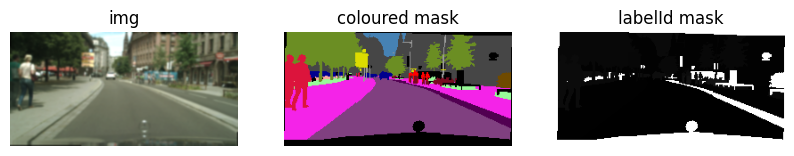

In [20]:

img, coloured_mask, labelId_mask, = next(iter(dataloader_train))
# Since img is a torch tensor (C, H, W) we have to permute its dimensions -> (H, W, C) before printing it

img1_np = denormalize(img[0], mean, std)
img1_np = img1_np.permute(1, 2, 0).numpy()
img2_np = coloured_mask[0].numpy()
img3_np = labelId_mask[0].numpy()

plt.figure(figsize=(10, 4))

plt.subplot(1, 3, 1)
plt.imshow(img1_np)
plt.title("img")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(img2_np)
plt.title("coloured mask")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(img3_np, cmap='gray')
plt.title("labelId mask")
plt.axis("off")

plt.show()

# Training

In [21]:
losses = []
unet.train()
for epoch in range(EPOCHS):
    epoch_losses = 0.0
    for i, batch in enumerate(dataloader_train):
        images = batch[0].to(device)
        # We use the labelIds_mask to train the network, not the coloured_mask
        labelIds_mask = batch[2].to(device)

        optimizer.zero_grad()

        outputs = unet(images)

        # Compute loss
        loss = criterion(outputs, labelIds_mask)
        epoch_losses += loss.item() * images.size(0)

        # Backward pass
        loss.backward()

        # Update parameters
        optimizer.step()
        print(f'EPOCH#{epoch},\t Batch#{i},\t Loss:{loss.item()}')
    losses.append(epoch_losses / len(dataloader_train.dataset))

EPOCH#0,	 Batch#0,	 Loss:2.972754955291748
EPOCH#0,	 Batch#1,	 Loss:2.899789333343506
EPOCH#0,	 Batch#2,	 Loss:2.7314560413360596
EPOCH#0,	 Batch#3,	 Loss:2.2083749771118164
EPOCH#0,	 Batch#4,	 Loss:1.9708410501480103
EPOCH#0,	 Batch#5,	 Loss:2.0005033016204834
EPOCH#0,	 Batch#6,	 Loss:1.973219633102417
EPOCH#0,	 Batch#7,	 Loss:1.8263300657272339
EPOCH#0,	 Batch#8,	 Loss:1.8121553659439087
EPOCH#0,	 Batch#9,	 Loss:1.689476490020752
EPOCH#0,	 Batch#10,	 Loss:1.5427062511444092
EPOCH#0,	 Batch#11,	 Loss:1.550050973892212
EPOCH#0,	 Batch#12,	 Loss:1.6129237413406372
EPOCH#0,	 Batch#13,	 Loss:1.5242788791656494
EPOCH#0,	 Batch#14,	 Loss:1.498386025428772
EPOCH#0,	 Batch#15,	 Loss:1.537817358970642
EPOCH#0,	 Batch#16,	 Loss:1.551282525062561
EPOCH#0,	 Batch#17,	 Loss:1.320039987564087
EPOCH#0,	 Batch#18,	 Loss:1.380430817604065
EPOCH#0,	 Batch#19,	 Loss:1.4490878582000732
EPOCH#0,	 Batch#20,	 Loss:1.2929039001464844
EPOCH#0,	 Batch#21,	 Loss:1.6575440168380737
EPOCH#0,	 Batch#22,	 Loss:1.42

[1.2514773364828413, 0.8320137882232665, 0.7498576149619928, 0.7022040470307614, 0.6457590854468466, 0.5962598593896177, 0.5763322574551366, 0.546357655925911, 0.5082612290101893, 0.4952293631209045]


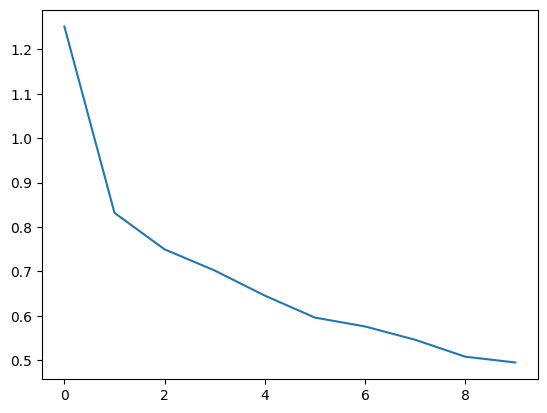

In [22]:
# Plot to see the evolution of the loss during the training
print(losses)
plt.plot(np.arange(len(losses)), losses)

In [23]:
# Save the model
PATH = '/kaggle/working/U-Net-Cityscapes_5.pth'
torch.save(unet.state_dict(), PATH)

In [73]:
# Load the model
PATH = '/kaggle/input/u-net5/pytorch/default/1/U-Net-Cityscapes_5.pth'
unet.load_state_dict(torch.load(PATH, device))

<All keys matched successfully>

# Test dataset implementation

In [74]:
# Definition of the dataset used to test the model
dataset_test = CityscapeDataset(root_path="/kaggle/input/cityscape-dataset", test=True, image_transform=image_transforms, mask_transform=mask_transforms)

In [75]:
# Definition of the dataloader to iteratively load the images/masks from the test dataset
dataloader_test = DataLoader(dataset=dataset_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=3)

# Testing

In [76]:
# Function to compute the Intersection over Union rate
'''
Takes as input:
    preds: tensor [B, C, H, W] -> output raw logits of the model
    targets: tensor [B, H, W] -> ground truth (trainId)
    num_classes: number of classes (e.g. 19 for Cityscapes)
    ignore_index: value to be ingored in the grounf truth targets (es. 255)
'''
def compute_iou_torch(preds, targets, num_classes=19, ignore_index=255):
    # Conversion from logits to classes
    preds = torch.argmax(preds, dim=1)  # [B, H, W]

    # Crafting the mask to ignore the 255 values
    mask = targets != ignore_index
    preds = preds[mask]
    targets = targets[mask]

    iou_per_class = torch.zeros(num_classes, device=preds.device)
    for c in range(num_classes):
        pred_c = preds == c
        target_c = targets == c

        intersection = (pred_c & target_c).sum().float()
        union = (pred_c | target_c).sum().float()

        # If the union == 0 then we ignore this result in the final iou computation
        if union == 0:
            iou_per_class[c] = torch.nan
        else:
            iou_per_class[c] = intersection / union

    mean_iou = torch.nanmean(iou_per_class)

    return iou_per_class, mean_iou


In [77]:
unet.eval()
total_iou = torch.zeros(19).to(device)
num_batches = 0

with torch.no_grad():
    for images, _, labels in tqdm(dataloader_test, desc="IoU", total=len(dataloader_test), unit="batch"):
        images = images.to(device)
        labels = labels.to(device)

        outputs = unet(images)
        iou_per_class, mean_iou = compute_iou_torch(outputs, labels)

        total_iou += torch.nan_to_num(iou_per_class)
        num_batches += 1

mean_iou_final = (total_iou / num_batches).mean()
print(f"Final mean IoU: {mean_iou_final.item():.4f}")
for i, iou in enumerate(iou_per_class):
    print(f"Class {i:02d} → IoU = {iou.item():.4f}")

IoU: 100%|██████████| 16/16 [00:27<00:00,  1.70s/batch]

Final mean IoU: 0.2680
Class 00 → IoU = 0.9268
Class 01 → IoU = 0.4179
Class 02 → IoU = 0.6763
Class 03 → IoU = 0.0253
Class 04 → IoU = 0.0019
Class 05 → IoU = 0.2151
Class 06 → IoU = 0.0066
Class 07 → IoU = 0.0374
Class 08 → IoU = 0.7808
Class 09 → IoU = 0.5415
Class 10 → IoU = 0.9378
Class 11 → IoU = 0.1638
Class 12 → IoU = 0.0000
Class 13 → IoU = 0.7196
Class 14 → IoU = 0.0000
Class 15 → IoU = 0.0000
Class 16 → IoU = nan
Class 17 → IoU = 0.0000
Class 18 → IoU = 0.0107


# Visual Benchmarks

In [78]:
# Cytiscapes color map for the 19 classes (trainId)
trainId2label = {
     0:  ("road", (128, 64,128)),
     1:  ("sidewalk", (244, 35,232)),
     2:  ("building", (70, 70, 70)),
     3:  ("wall", (102,102,156)),
     4:  ("fence", (190,153,153)),
     5:  ("pole", (153,153,153)),
     6:  ("traffic light", (250,170, 30)),
     7:  ("traffic sign", (220,220,  0)),
     8:  ("vegetation", (107,142, 35)),
     9:  ("terrain", (152,251,152)),
    10: ("sky", (70,130,180)),
    11: ("person", (220, 20, 60)),
    12: ("rider", (255,  0,  0)),
    13: ("car", (0,  0,142)),
    14: ("truck", (0,  0, 70)),
    15: ("bus", (0, 60,100)),
    16: ("train", (0, 80,100)),
    17: ("motorcycle", (0,  0,230)),
    18: ("bicycle", (119, 11, 32))
}

In [79]:
'''
Function to convert the grayscale labelIds to an rgb image in order to be compared
to the coloured ground truth mask
Input:
        mask: torch.Tensor [H, W] or np.ndarray [H, W]
    Output:
        color_mask: np.ndarray [H, W, 3] (uint8)
'''
def colorize_mask(mask):
    if torch.is_tensor(mask):
        mask = mask.cpu().numpy()

    color_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)

    for train_id, (label_name, color) in trainId2label.items():
        color_mask[mask == train_id] = color

    return color_mask

In [80]:
# Function to print in the same plot three different images
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        if(i in (1,2)):
            plt.imshow(display_list[i])
        else:
            plt.imshow(display_list[i].permute(1, 2, 0))
        plt.axis('off')
    return plt

In [81]:
# Function that converts the logits to the actual classes
def create_mask(pred_mask):
    pred_mask = torch.argmax(pred_mask, dim=1).detach()
    return pred_mask

In [82]:
# Function that displays the first image of each of the num batches
def show_predictions(dataloader, device, num=1):
    unet.eval()

    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            # RGB image
            IMG = batch[0][0, :, : ,:].to(device).unsqueeze(0)
            # Coloured mask
            MASK = batch[1][0, :, :, :].to(device).unsqueeze(0)
            # LabelIds prediction
            pred_mask = unet.to(device)(IMG)
            # Plotting the three images next to each other
            display([denormalize(IMG[0].cpu(), mean, std), MASK[0].cpu(), colorize_mask(create_mask(pred_mask).cpu()[0])]).show()

            if i >= num:
                break

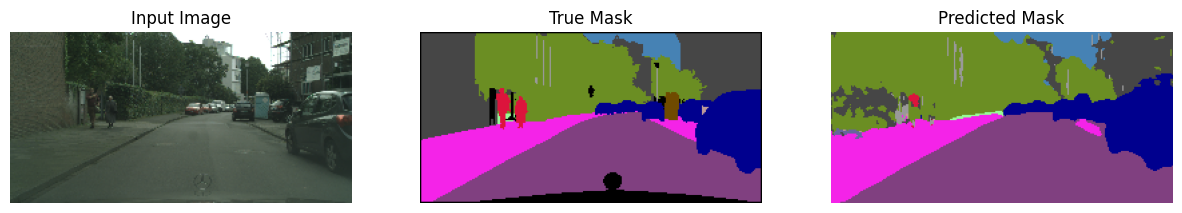

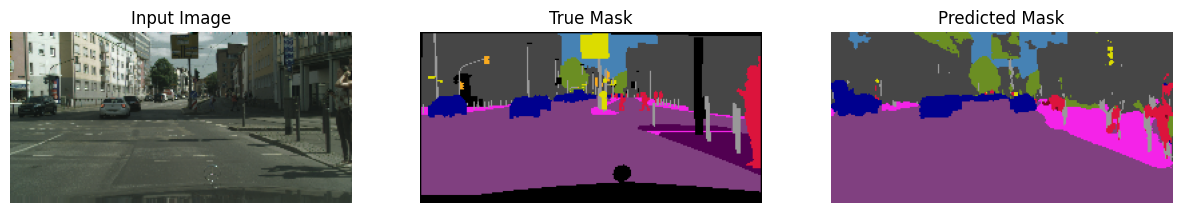

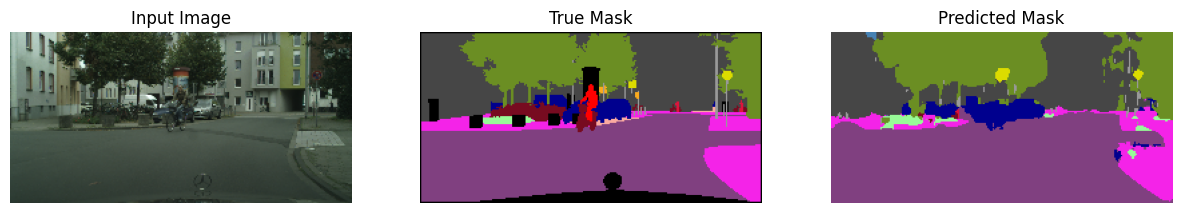

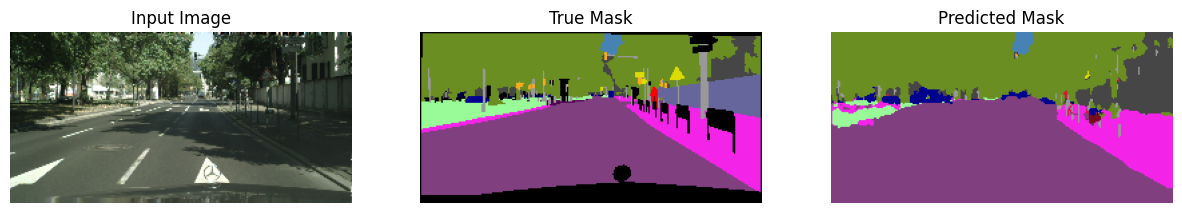

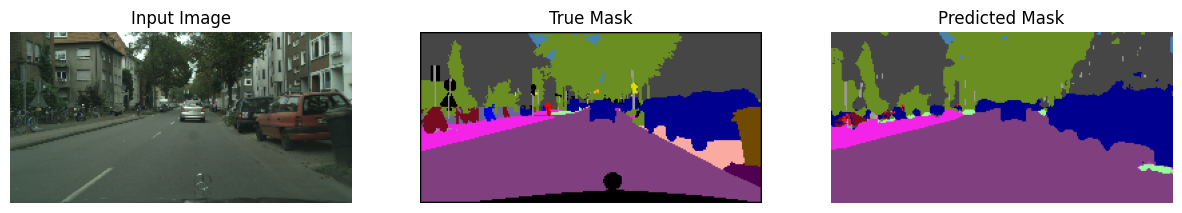

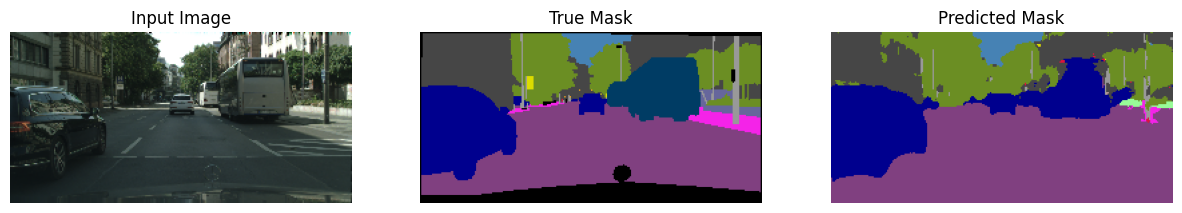

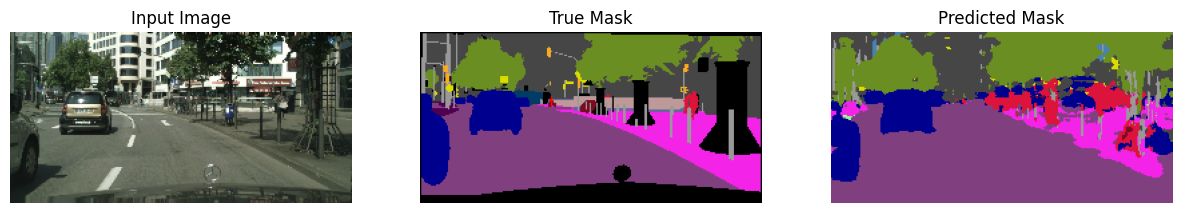

In [83]:
# Showing n random images from the test dataset with the ground truth mask and the predicted mask
shuffled_dataloader_test = DataLoader(dataset=dataset_test, batch_size=BATCH_SIZE, shuffle=True, num_workers=3)
show_predictions(shuffled_dataloader_test, device, 6)

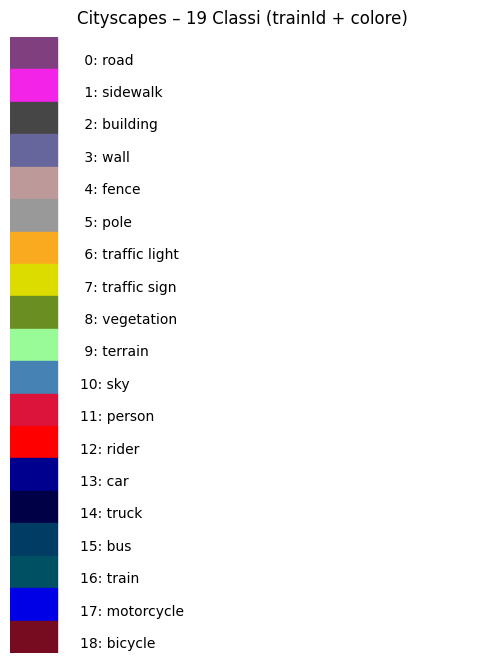

In [ ]:
# Create the plot
fig, ax = plt.subplots(figsize=(6, 8))
ax.set_xlim(0, 10)
ax.set_ylim(0, len(trainId2label))
ax.axis("off")

# Draw the small coloured rectangles with the class name
for i, (train_id, (name, color)) in enumerate(trainId2label.items()):
    y = len(trainId2label) - i - 1
    rgb = np.array(color) / 255.0  # matplotlib normalization
    ax.add_patch(plt.Rectangle((0, y), 1, 1, color=rgb))
    ax.text(1.5, y + 0.3, f"{train_id:2d}: {name}", fontsize=10, va="center")

plt.title("Cityscapes – 19 Classi (trainId + colore)", fontsize=12, pad=10)
plt.show()
